In [47]:
import numpy as np
import sys
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
sys.path.append('../../../')

# Import do_mpc package:
import do_mpc

In [48]:

model = do_mpc.model.Model('continuous', 'MX')

In [61]:
g = 9.80665 # m/s^2, Gravity
N = 2

In [63]:
x = MX.sym('x',N,2)
y = MX.sym('y',2)
f = Function('f',[x,y],\
           [x + y.T])
print(f)
f([[2,1],[5,5]],[4,-10])

RuntimeError: .../casadi/core/mx.cpp:521: Dimension mismatch for (x+y), x is 2x2, while y is 1x2

In [46]:



pos = model.set_variable('_x',  'pos',shape=(N,2))
dpos = model.set_variable('_x',  'dpos',shape=(N,2))

print(model.x.labels())
u = model.set_variable('_u',  'force')

ddpos = model.set_variable('_z', 'ddpos')

['[pos,0]', '[pos,1]', '[pos,2]', '[pos,3]', '[pos,4]', '[pos,5]', '[pos,6]', '[pos,7]', '[pos,8]', '[pos,9]', '[pos,10]', '[pos,11]', '[pos,12]', '[pos,13]', '[pos,14]', '[pos,15]', '[pos,16]', '[pos,17]', '[pos,18]', '[pos,19]', '[dpos,0]', '[dpos,1]', '[dpos,2]', '[dpos,3]', '[dpos,4]', '[dpos,5]', '[dpos,6]', '[dpos,7]', '[dpos,8]', '[dpos,9]', '[dpos,10]', '[dpos,11]', '[dpos,12]', '[dpos,13]', '[dpos,14]', '[dpos,15]', '[dpos,16]', '[dpos,17]', '[dpos,18]', '[dpos,19]']


In [5]:
model.set_rhs('pos', dpos)
model.set_rhs('dpos', ddpos)
model.set_rhs('time', 1)

In [6]:
formulas = vertcat(
        # 1
        u
        - (ddpos),
    )

model.set_alg('formulas', formulas)

In [7]:

distance = (100-pos)**2


model.set_expression('distance', distance)

SX(sq((100-pos)))

In [8]:
# Build the model
model.setup()

In [9]:
mpc = do_mpc.controller.MPC(model)

In [10]:
setup_mpc = {
    'n_horizon': 100,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.04,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

In [11]:
mterm = model.aux['distance'] # terminal cost
lterm = model.aux['distance'] # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)
# Input force is implicitly restricted through the objective.
mpc.set_rterm(force=0.1)

In [12]:
mpc.bounds['lower','_u','force'] = -1000
mpc.bounds['upper','_u','force'] = 1000

In [13]:
mpc.setup()

In [14]:
estimator = do_mpc.estimator.StateFeedback(model)

In [15]:
simulator = do_mpc.simulator.Simulator(model)

In [16]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'idas',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.04
}

simulator.set_param(**params_simulator)

In [17]:
simulator.setup()

In [18]:
simulator.x0['pos'] = 10

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()


In [19]:
import matplotlib.pyplot as plt
plt.ion()
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [20]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

In [21]:
%%capture

fig = plt.figure(figsize=(16,9))


ax2 = plt.subplot2grid((4, 2), (0, 1))

ax4 = plt.subplot2grid((4, 2), (2, 1))
ax5 = plt.subplot2grid((4, 2), (3, 1))

ax2.set_ylabel('distance')

ax4.set_ylabel('Pos ')
ax5.set_ylabel('U')

# Axis on the right.
for ax in [ax2, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])

ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='distance', axis=ax2)

mpc_graphics.add_line(var_type='_x', var_name='pos', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax5)


fig.align_ylabels()
fig.tight_layout()

In [22]:
u0 = mpc.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4602
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      300

Total number of variables............................:     1510
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equa

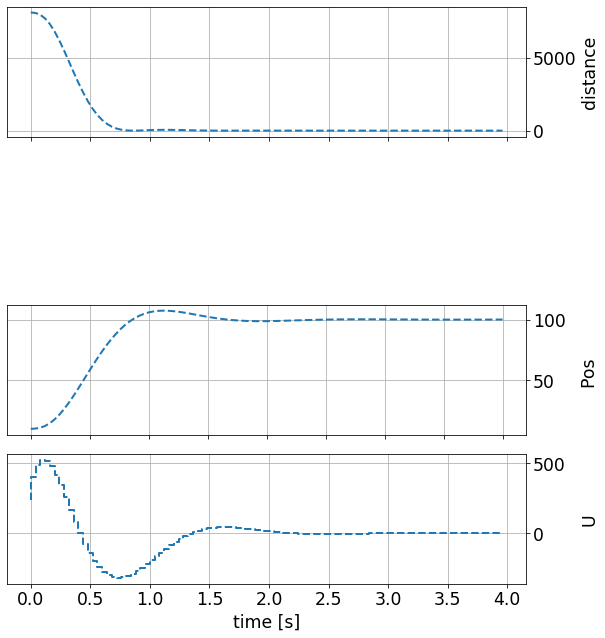

In [23]:


mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

In [24]:
%%capture
# Quickly reset the history of the MPC data object.
mpc.reset_history()

n_steps = 100
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [28]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
#     line1, line2 = pendulum_bars(x_arr[t_ind])
#     bar1[0].set_data(line1[0],line1[1])
#     bar2[0].set_data(line2[0],line2[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()


anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)
gif_writer = ImageMagickWriter(fps=20)
anim.save('anim.gif', writer=gif_writer)

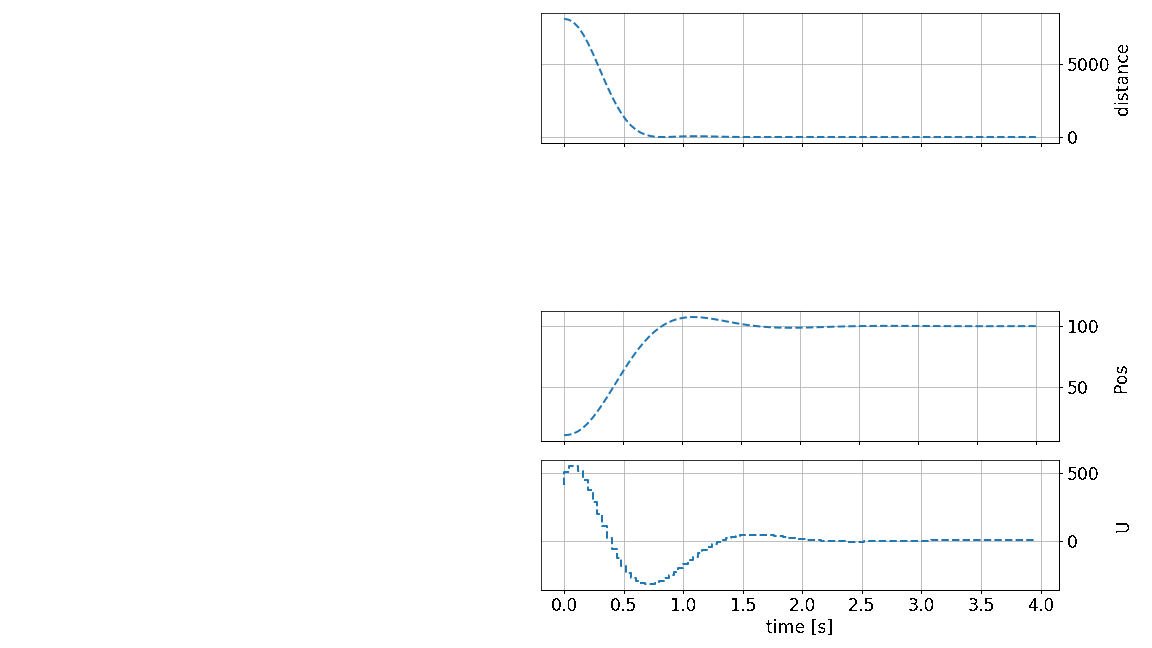

In [29]:
from IPython.display import HTML, Image
display(Image(data=open("anim.gif",'rb').read(), format='png'))